# Анализ данных и построенных контуров

Загружаем нужные библиотеки и имеющиеся данные

In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from sequence import *

datas = []
for subdir, dirs, files in os.walk('datasets'):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".dat"):
            datas.append(np.loadtxt(filepath))
n = len(datas)

## Поиск зависимости количества пропусков и петель от размера входных данных

In [2]:
plot_data = []
for data in tqdm(datas):
    seq = Sequence(data)
    _, nuniq = seq.is_data_unique(return_not_unique=True)
    _, md = seq.sorted(key='nn_md').have_missed_data(return_num=True)
    _, loops = seq.sorted(key='nn_loops').have_loops(return_num=True)
    plot_data.append([seq.get_data_len(), len(md), loops, len(nuniq)])
    
plot_data = np.array(sorted(plot_data))

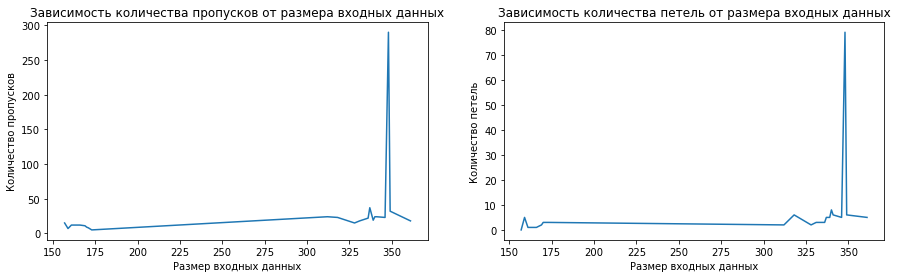

In [3]:
fig, ax = plt.subplots(1,2, figsize=(15, 4))

ax[0].plot(plot_data[:,0], plot_data[:,1])
ax[0].set_title("Зависимость количества пропусков от размера входных данных")
ax[0].set_xlabel("Размер входных данных")
ax[0].set_ylabel("Количество пропусков")

ax[1].plot(plot_data[:,0], plot_data[:,2])
ax[1].set_title("Зависимость количества петель от размера входных данных")
ax[1].set_xlabel("Размер входных данных")
ax[1].set_ylabel("Количество петель")

plt.savefig("statistic/data_analysis.png")
plt.show()

## Каким требованиям удовлетворяют контуры, построенные алгоритмами

Функция для сохранения таблиц в формате, удобном для вставки в диплом

In [4]:
def save_table_tex(table, table_name='output', fmt='%.5f'):
    np.savetxt("statistic/"+table_name+".txt", table, fmt=fmt, 
              delimiter=' & ', newline=" \\\\ \n\hline\n")  

Сбор информации для таблицы

In [6]:
results_req = {}
for alg in tqdm(sort_dict):
    res = np.array([*Sequence(datas[0]).sorted(key=alg).is_contour(return_all=True).values()]).astype(int)
    for i, data in enumerate(datas[1:]):
        res1 = np.array([*Sequence(data).sorted(key=alg).is_contour(return_all=True).values()]).astype(int)
        res += res1
        
    res[0] = n - res[0]
    res[1] = n - res[1]
    
    results_req[alg] = res

Таблица с количеством датасетов, где соответствующие алгоритмы справились с требованиями

In [10]:
def highlight_max(data, color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data > 0.89
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data['Is contour'] > 0.89
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)
    

req_name = ['No missed data', 'No loops', 'Is single contour', 'Solve the problem']
df_req = pd.DataFrame(data=results_req).T  
df_req.columns = req_name
df_req = df_req.div(n)
save_table_tex(df_req.to_numpy(),'req.txt')
# ds = df_req.style.apply(highlight_max, subset=['Is contour'])
df_req.style.apply(highlight_max, subset=['Solve the problem']).format("{:.0%}")

,No missed data,No loops,Is single contour,Solve the problem
nn,100%,0%,43%,0%
nn_md,0%,5%,95%,0%
nn_loops,100%,5%,95%,5%
nn_no_loops,100%,95%,95%,95%
nn_21_loops,100%,5%,100%,5%
nn_21_no_loops,100%,100%,100%,100%
polar,100%,100%,100%,100%
ch,0%,100%,100%,0%
ch_loops,100%,5%,100%,5%
ch_no_loops,100%,100%,100%,100%


## Длины полученных контуров

Вывод длины контуров, полученных при использовании алгоритмов, которые справились с задачей хотя бы на 90%

In [11]:
good_algs = ['nn_no_loops', 'nn_21_no_loops', 'polar', 'ch_no_loops', 'best']
results_len = {}

for ind,data in enumerate(tqdm(datas)):
    res = []
    seq = Sequence(data)
    for alg in good_algs:
        res.append(seq.sorted(key=alg).get_contour_len())
    
    results_len[ind+1] = res     
    

In [12]:
alg_name = ['Улучшенный алгоритм ближайшего соседа', 'Вставка второго контура в первый','Сортировка по полярным координатам','Вставка точек в выпуклую оболочку','Объединение алгоритмов']
df = pd.DataFrame(data=results_len).T  
df.columns = alg_name
save_table_tex(df.to_numpy(),'length.txt')
df.style.highlight_min(color='lightgreen',axis = 1)

,Улучшенный алгоритм ближайшего соседа,Вставка второго контура в первый,Сортировка по полярным координатам,Вставка точек в выпуклую оболочку,Объединение алгоритмов
1,107.617793,114.346084,214.703372,110.316070,107.617793
2,113.762904,121.640873,354.841596,128.612149,113.762904
3,180.971359,131.146411,419.436392,141.190250,131.146411
4,119.763647,124.749270,258.073714,127.788364,119.763647
5,121.460905,129.124599,361.100414,130.957475,121.460905
6,118.455023,124.884436,250.910628,132.632650,118.455023
7,117.784171,125.161153,320.829496,133.476444,117.784171
8,108.103099,114.756496,160.167858,115.162566,108.103099
9,118.616352,122.467534,245.444132,129.453873,118.616352
10,105.398196,111.004245,210.667829,122.149726,105.398196
